In [56]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pathlib
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [3]:
#we assume each subdirectory in train_dir contains one class of images
#and the subdirectory's name is the class name
train_dir = "data"
train_dir = pathlib.Path(train_dir)
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*')])
print(CLASS_NAMES)
class_num = len(CLASS_NAMES)

#settings I got online, can be changed according to our data
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

['spiral' 'elliptical' 'irregular']


In [4]:
#image generator that using different augmentations to give us more data points
#split the data into training/validation with 0.8/0.2
image_generator = ImageDataGenerator(
                        rescale=1./255,
                        rotation_range=45,
                        width_shift_range=.15,
                        height_shift_range=.15,
                        horizontal_flip=True,
                        zoom_range=0.5,
                        validation_split=0.2)

In [5]:
#using the above generate get data flow from directory
train_data_gen = image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),                                         
                                                           subset='training',
                                                           classes = list(CLASS_NAMES))

val_data_gen = image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=train_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              subset='validation',
                                                              classes = list(CLASS_NAMES))

Found 3083 images belonging to 3 classes.
Found 769 images belonging to 3 classes.


In [8]:
#A simple Sequential model
#last line is needed for multi-class classification, others can be changed
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
   	Dense(class_num,activation='softmax')
])

In [9]:
#compile the model
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

In [10]:
#fit the model using data generator
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size
)

Epoch 1/15
24/24 [==============================] - 29s 1s/step - loss: 0.6100 - acc: 0.8467 - val_loss: 0.5013 - val_acc: 0.8620
Epoch 2/15
24/24 [==============================] - 30s 1s/step - loss: 0.4032 - acc: 0.8646 - val_loss: 0.3685 - val_acc: 0.8750
Epoch 3/15
24/24 [==============================] - 30s 1s/step - loss: 0.3643 - acc: 0.8640 - val_loss: 0.3196 - val_acc: 0.8854
Epoch 4/15
24/24 [==============================] - 29s 1s/step - loss: 0.3073 - acc: 0.8782 - val_loss: 0.3098 - val_acc: 0.8789
Epoch 5/15
24/24 [==============================] - 29s 1s/step - loss: 0.3144 - acc: 0.8755 - val_loss: 0.3077 - val_acc: 0.8880
Epoch 6/15
24/24 [==============================] - 32s 1s/step - loss: 0.2897 - acc: 0.8796 - val_loss: 0.3136 - val_acc: 0.8789
Epoch 7/15
24/24 [==============================] - 31s 1s/step - loss: 0.2739 - acc: 0.8866 - val_loss: 0.3042 - val_acc: 0.8815
Epoch 8/15
24/24 [==============================] - 31s 1s/step - loss: 0.3055 - acc: 0.87

In [11]:
#get accuracy and loss 
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

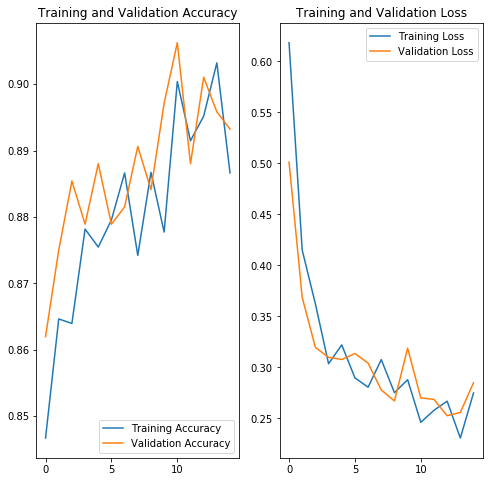

In [12]:
#plot training and validation accuracy and loss
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
#get the actual labels for the test data (we use validation data as test data for now)
number_of_examples = len(val_data_gen.filenames)
number_of_generator_calls = np.ceil(number_of_examples / (1.0 * batch_size)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(val_data_gen[i][1]))
    
print(test_labels[0])

[1. 0. 0.]


In [45]:
#make prediction on the test data
pre = np.round(model_new.predict_generator(val_data_gen))
print(pre)


[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


[[636  27   0]
 [ 12  45   0]
 [ 47   1   1]]
Confusion matrix, without normalization


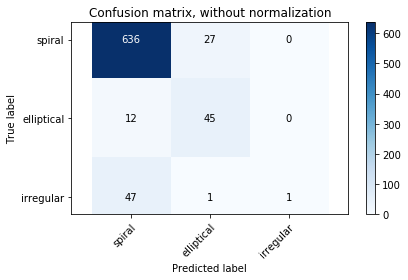

In [73]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = np.array(confusion_matrix(y_true, y_pred))
    print(cm);
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    ax.axis('equal')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax
y_true = np.nonzero(test_labels)[1].astype(int)
y_pred = np.nonzero(pre)[1].astype(int)

plot_confusion_matrix(y_true,y_pred , CLASS_NAMES)